# Content-Aware Image Retargeting
Reduce the width of images (`Baby.png`, `Diana.png`, `Snowman.png`) by `seams_number` columns using Seam Carving, implemented from scratch. Optionally use depth/saliency maps or other energy functions. Visualize seams if enabled.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

def compute_energy(image, depth_map=None, saliency_map=None):
    gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY).astype(np.float32)

   
    dx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    dy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
    energy = np.abs(dx) + np.abs(dy)

    if depth_map is not None:
        energy += depth_map.astype(np.float32)
    if saliency_map is not None:
        energy += saliency_map.astype(np.float32)

    return energy



def find_seam(energy):
    h, w = energy.shape
    M = energy.copy()
    backtrack = np.zeros_like(M, dtype=np.int32)

    for i in range(1, h):
        for j in range(w):
            left = max(j-1, 0)
            right = min(j+1, w-1)
            idx = np.argmin(M[i-1, left:right+1]) + left
            M[i, j] += M[i-1, idx]
            backtrack[i, j] = idx

    # بازسازی seam از پایین به بالا
    seam = []
    j = np.argmin(M[-1])
    seam_energy = M[-1, j]  

    for i in reversed(range(h)):
        seam.append((i, j))
        j = backtrack[i, j]

    return seam[::-1], seam_energy


def remove_seam(image, seam):
    h, w = image.shape[:2]


    mask = np.ones((h, w), dtype=bool)
    for i, j in seam:
        mask[i, j] = False

    
    if image.ndim == 3:
        mask = np.stack([mask] * image.shape[2], axis=2)
        new_image = image[mask].reshape(h, w - 1, image.shape[2])
    else: 
        new_image = image[mask].reshape(h, w - 1)

    return new_image



def seam_carving(image, num_seams, depth_map=None, saliency_map=None, visualize=False):
    img = image.copy()
    dmap = depth_map.copy() if depth_map is not None else None
    smap = saliency_map.copy() if saliency_map is not None else None
    energies = []

    for _ in range(num_seams):
        energy = compute_energy(img, dmap, smap)
        seam, seam_energy = find_seam(energy)
        seam_energies.append(seam_energy)


        
        img = remove_seam(img, seam)

        
        if dmap is not None:
            dmap = remove_seam(dmap, seam)

        
        if smap is not None:
            smap = remove_seam(smap, seam)

        energies.append(np.sum([energy[i, j] for i, j in seam]))

        
        if visualize:
            vis = img.copy()
            for i, j in seam:
                vis[i, j] = (0, 0, 255)
            cv2.imshow("Seam", vis)
            cv2.waitKey(1)

    if visualize:
        cv2.destroyAllWindows()

    return img, energies


In [14]:
def seam_carving(image, seams_number, depth_map=None, saliency_map=None, visualize=False):
    """Perform Seam Carving to reduce image width by seams_number columns.

    Args:
        image: Input image (H, W, 3) as float32 in [0, 1].
        seams_number: Number of vertical seams to remove.
        depth_map: Optional depth map (H, W) as float32.
        saliency_map: Optional saliency map (H, W) as float32.
        visualize: If True, display seams during processing.

    Returns:
        resized_image: Image with reduced width.
        seam_energies: List of cumulative energies of removed seams.
    """
    seam_energies = []
    img = image.copy()

    for s in range(seams_number):
        # 1. Compute energy map
        energy = compute_energy(img, depth_map, saliency_map)

        # 2. Find seam with lowest energy
        seam, seam_energy = find_seam(energy)
        seam_energies.append(seam_energy)

        # 3. Visualize seam (اختیاری)
        if visualize and (s % 20 == 0 or s == seams_number - 1):
            vis = visualize_seam(img, seam)
            plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
            plt.title(f"Seam {s+1}")
            plt.axis("off")
            plt.show()

        # 4. Remove seam from image
        img = remove_seam(img, seam)

        # 5. Remove seam also from depth/saliency maps (if provided)
        if depth_map is not None:
            depth_map = remove_seam(np.expand_dims(depth_map, 2), [(i, j) for i, j in seam])[:, :, 0]
        if saliency_map is not None:
            saliency_map = remove_seam(np.expand_dims(saliency_map, 2), [(i, j) for i, j in seam])[:, :, 0]

    return img, seam_energies


In [15]:
# Load images and maps
baby_path = r'C:\Users\Kavosh\Desktop\techstack2025-ai\week3\task\part2_CAIR\images\Baby\Baby.png'
baby_dmap_path = r'C:\Users\Kavosh\Desktop\techstack2025-ai\week3\task\part2_CAIR\images\Baby\Baby_DMap.png'
baby_smap_path = r'C:\Users\Kavosh\Desktop\techstack2025-ai\week3\task\part2_CAIR\images\Baby\Baby_SMap.png'

baby = cv2.imread(baby_path).astype(np.float32) / 255.0
baby_dmap = cv2.imread(baby_dmap_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
baby_smap = cv2.imread(baby_smap_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0

# Parameters
seams_number = 200
visualize = True

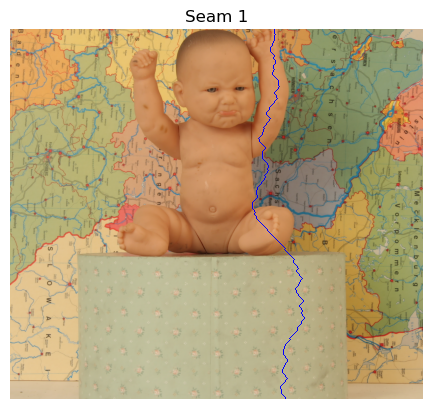

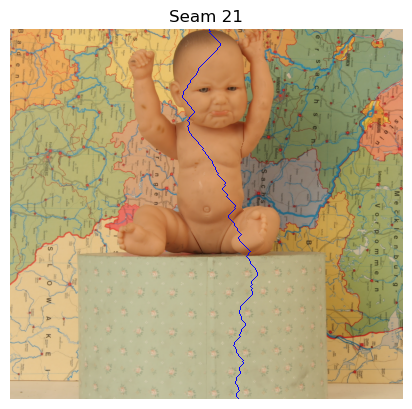

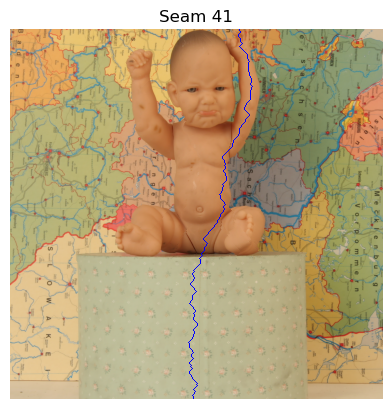

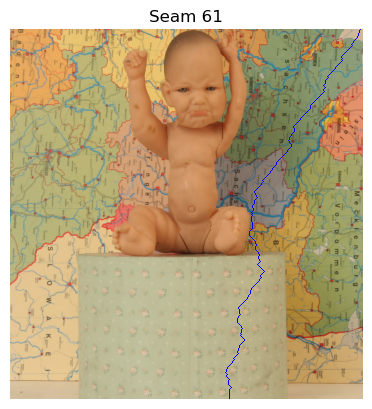

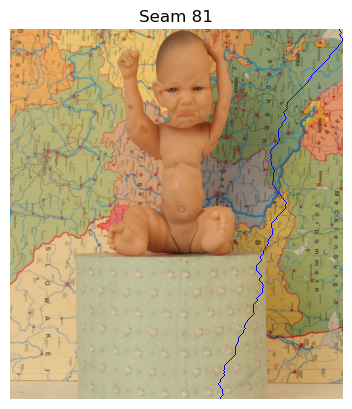

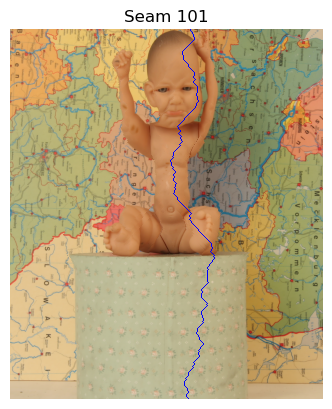

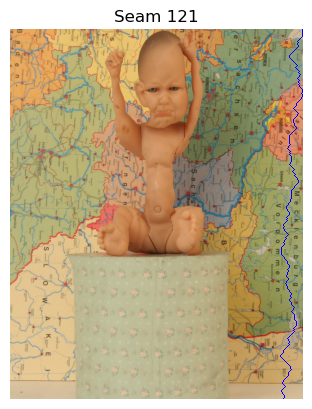

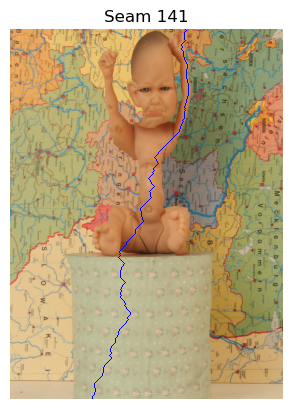

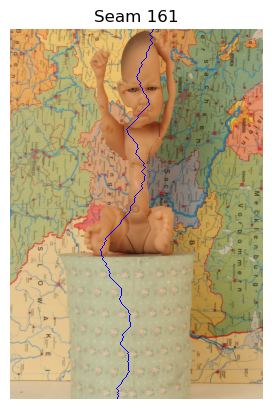

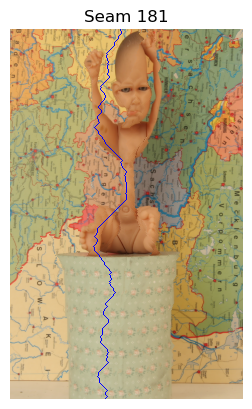

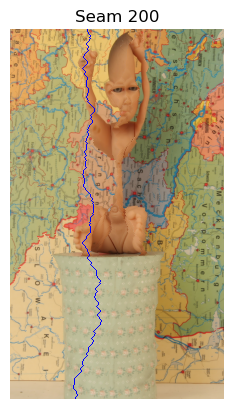

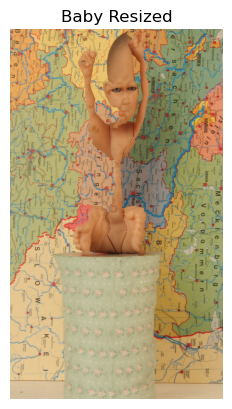

True

In [16]:
# Process images
baby_resized, baby_energies = seam_carving(baby, seams_number, baby_dmap, baby_smap, visualize)

# Save seam energies
with open('seam_energy_log.txt', 'w') as f:
    f.write('Baby Seam Energies:\n' + '\n'.join(map(str, baby_energies)) + '\n')

# Visualize results
plt.imshow(cv2.cvtColor(baby_resized, cv2.COLOR_BGR2RGB))
plt.title('Baby Resized')
plt.axis('off')
plt.show()

# Save resized images
cv2.imwrite('Baby_resized.png', (baby_resized * 255).astype(np.uint8))